# Part 2 Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import nltk
from sklearn.feature_extraction.text import CountVectorizer
import string
import re
import nltk

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

import os
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer

from nltk.util import ngrams 
from collections import Counter
from functools import reduce


import pickle

pd.options.display.max_columns = None

In [2]:
with open('./pickled_df/preprocess_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.head()

,title,text,subject,date,target,title_text
0,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,2015-03-31,1,benghazi panel call hillary testify oath white...
1,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,left-news,2015-03-31,1,hillary rodham nixon candidate baggage samsoni...
2,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",left-news,2015-03-31,1,watch dirty harry reid lie romneys tax didnt w...
3,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,politics,2015-03-31,1,oh guess funded shrine ted kennedy nothing lik...
4,FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...,Just making room for Hillary President Obama t...,politics,2015-03-31,1,flashback king obama commute sentence drug dea...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39097 entries, 0 to 39096
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   title       39097 non-null  object        
 1   text        39097 non-null  object        
 2   subject     39097 non-null  object        
 3   date        39097 non-null  datetime64[ns]
 4   target      39097 non-null  int64         
 5   title_text  39097 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.8+ MB


### Exploratory Data Analysis

**Class Balance Analysis**

In [5]:
df['target'].value_counts(normalize=True)

0    0.542139
1    0.457861
Name: target, dtype: float64

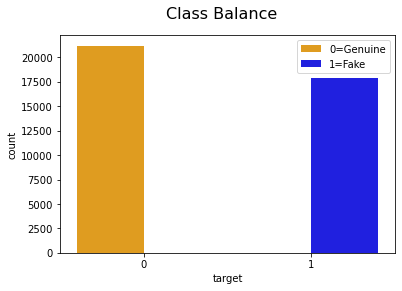

In [6]:
palette ={0: "Orange", 1: "Blue"}

ax=sns.countplot(data = df, x='target', palette = palette, hue='target')
plt.legend(labels = ['0=Genuine', '1=Fake'])
plt.suptitle('Class Balance', fontsize=16);

The class distribution is slightly imbalance but acceptable.

#### Total Number of Data per Subject

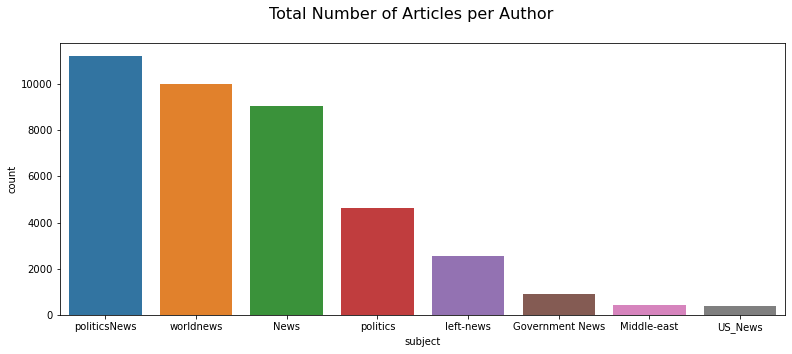

In [7]:
plt.figure(figsize=(13, 5))
sns.countplot(data =df, x='subject',
              order = df['subject'].value_counts().index)
plt.suptitle('Total Number of Articles per Author', fontsize=16);


#### Articles by target

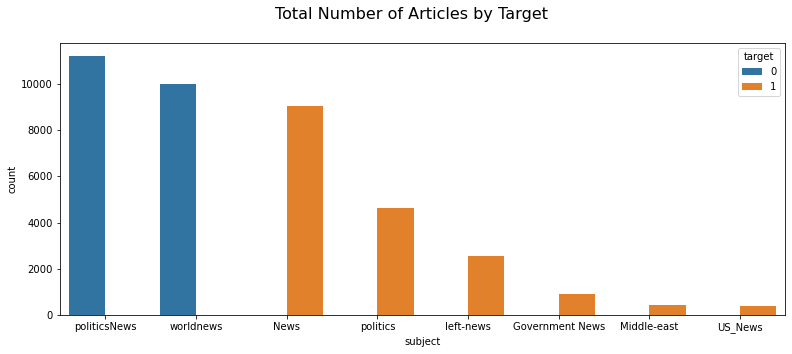

In [8]:
plt.figure(figsize=(13, 5))
sns.countplot(data =df, x='subject',
              order = df['subject'].value_counts().index,
             hue = 'target')
plt.suptitle('Total Number of Articles by Target', fontsize=16);

- There are only two authors that publish genuine articles while there at 6 authors that publish fake news. 
- Including 'subject' column in our further exploration and analysis will have a significant impact on the results. As such, I will drop this column. 

**Period of Data**

In [9]:
# Create 4 new columns: Year, Month, Day, Week from the Date column
def create_yr_day_mth(df): 
    df['year'] = [dd.year for dd in pd.DatetimeIndex(df.date.values)]
    df['month'] = [dd.month for dd in pd.DatetimeIndex(df.date.values)]
    return df.head()

In [10]:
#create year, month, day, week
create_yr_day_mth(df)

,title,text,subject,date,target,title_text,year,month
0,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,2015-03-31,1,benghazi panel call hillary testify oath white...,2015,3
1,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,left-news,2015-03-31,1,hillary rodham nixon candidate baggage samsoni...,2015,3
2,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",left-news,2015-03-31,1,watch dirty harry reid lie romneys tax didnt w...,2015,3
3,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,politics,2015-03-31,1,oh guess funded shrine ted kennedy nothing lik...,2015,3
4,FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...,Just making room for Hillary President Obama t...,politics,2015-03-31,1,flashback king obama commute sentence drug dea...,2015,3


**Find earliest and latest date**

In [11]:
#find min and max date of dataset
df.date.min(), df.date.max()

(Timestamp('2015-03-31 00:00:00'), Timestamp('2018-02-19 00:00:00'))

- The earliest data present in the dataset is 31 March 2015
- The latest data present in the dataset is 19 February 2018
- The data is not current, will affect accuracies if test on current year news articles

**Distribution of news article by period**

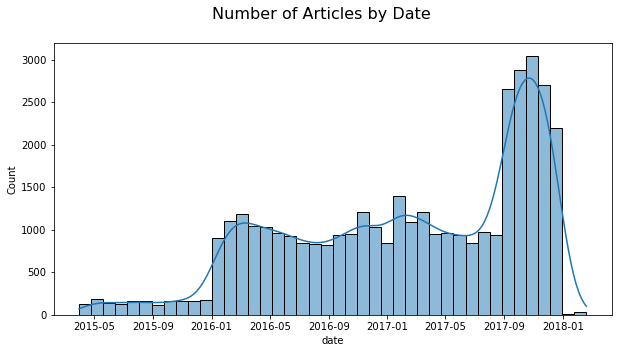

In [12]:
#distribution plot
plt.figure(figsize=(10, 5))
sns.histplot(data = df, x = 'date', kde = True)
plt.suptitle('Number of Articles by Date ', fontsize=16);

- Highly skewed
- More articles published between September 2017 and Dec 2017 than the rest of the period

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,39097.0,0.457861,0.498228,0.0,0.0,0.0,1.0,1.0
year,39097.0,2016.555055,0.576990,2015.0,2016.0,2017.0,2017.0,2018.0
month,39097.0,7.288181,3.529763,1.0,4.0,8.0,10.0,12.0


**Distribution by year**

In [14]:
df.year.value_counts()

2017    23276
2016    14141
2015     1645
2018       35
Name: year, dtype: int64

In [15]:
df.groupby('year')['target'].value_counts()

year  target
2015  1          1645
2016  1          9443
      0          4698
2017  0         16498
      1          6778
2018  1            35
Name: target, dtype: int64

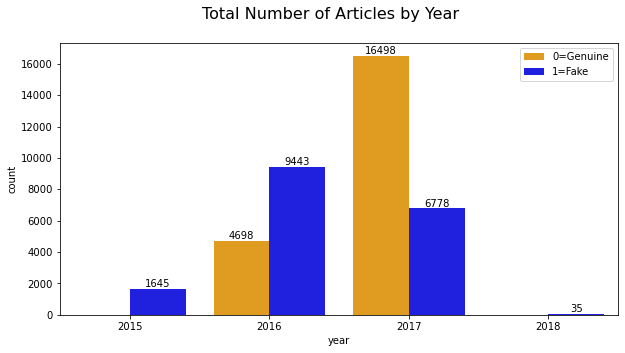

In [16]:
palette ={0: "Orange", 1: "Blue"}
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='year', data=df, hue = 'target', palette = palette)
for container in ax.containers:
    ax.bar_label(container)
plt.legend(labels = ['0=Genuine', '1=Fake'])
plt.suptitle('Total Number of Articles by Year', fontsize=16);

- The presence of genuine news shot up by threefolds from 2016 to 2017, overtaking the number of fake news
- This is rightly so as by publishing genuine/real news helps public make informed voting decision, at the same time suppressing the presence of fake news

**Distribution by Month**

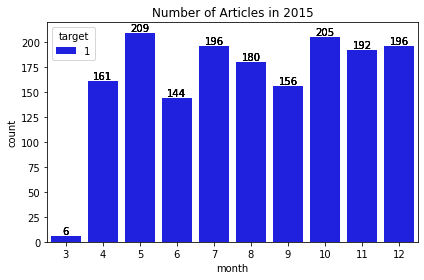

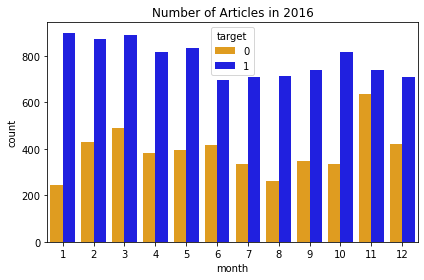

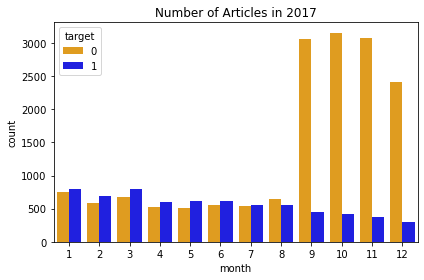

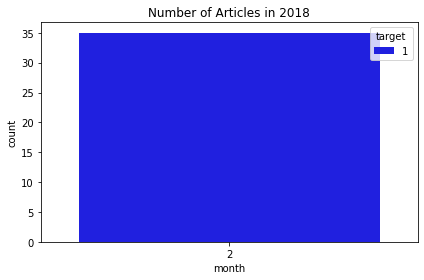

<Figure size 432x288 with 0 Axes>

In [17]:
palette ={0: "Orange", 1: "Blue"}

fig, ax = plt.subplots()

ax = sns.countplot(x='month', data=df[df.year == 2015], hue = 'target', palette = palette)
for container in ax.containers:
    ax.bar_label(container)
ax.title.set_text('Number of Articles in 2015')
plt.tight_layout()
plt.figure();

ax2 = sns.countplot(x='month', data=df[df.year == 2016], hue = 'target', palette = palette)
for container in ax.containers:
    ax.bar_label(container)
ax2.title.set_text('Number of Articles in 2016')    
plt.tight_layout()
plt.figure();

ax3 = sns.countplot(x='month', data=df[df.year == 2017], hue = 'target', palette = palette)
for container in ax.containers:
    ax.bar_label(container)
ax3.title.set_text('Number of Articles in 2017') 
plt.tight_layout()
plt.figure();

ax4 = sns.countplot(x='month', data=df[df.year == 2018], hue = 'target', palette = palette)
for container in ax.containers:
    ax.bar_label(container)

ax4.title.set_text('Number of Articles in 2018')    
plt.tight_layout()
plt.figure();

- There are no specific pattern noted on the distribution of articles monthly.
- Fake news appear to be rampant year on year but more efforts to publish genuine news were made approaching election

**Sources of Fake and Genuine News**

In [18]:
df.groupby('target')['subject'].value_counts()

target  subject        
0       politicsNews       11210
        worldnews           9986
1       News                9050
        politics            4616
        left-news           2548
        Government News      904
        Middle-east          408
        US_News              375
Name: subject, dtype: int64

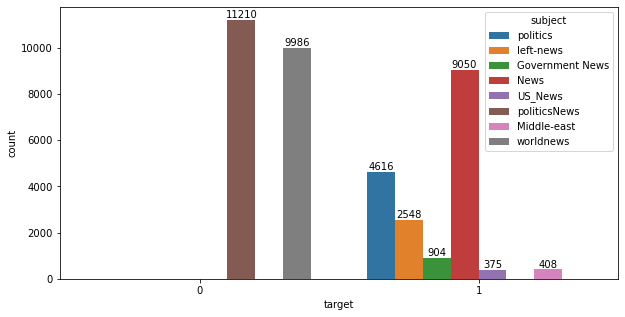

In [19]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='target', data=df, hue='subject')
for container in ax.containers:
    ax.bar_label(container);

- Real news sources are from politicsNews & worldnews
- The rest are sources of fake news

In [20]:
#number of characters in each string
df['num_char'] = df['title_text'].str.strip().str.len()

#capture number of words in each text
df['num_words'] = df['title_text'].str.split().str.len()

#capture number of unique words in each text
df['num_vocab'] = df['title_text'].str.lower().str.split().apply(set).str.len()

#calculate average word length by diving number if characters by the number of words
df['ave_word_length'] = df['num_char'] / df['num_words']

In [21]:
real_news_char = df[df.target == 0].num_char
fake_news_char = df[df.target == 1].num_char

In [22]:
def hist_plot(real_df, fake_df, title):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

    ax1.hist(real_df,color='orange')
    ax1.set_title('Real News', fontsize=10)

    ax2.hist(fake_df,color='blue')
    ax2.set_title('Fake News', fontsize=10)

    fig.suptitle(title, fontsize=16)
    plt.show();

In [23]:
from scipy import stats
def stats_val(real, fake):
    print("----Real News----")
    print("Mean: ",real.mean(), " Mode: ",real.mode(), " Median: ", real.median())
    print("----Fake News----")
    print("Mean: ",fake.mean(), " Mode: ",fake.mode(), " Median: ", fake.median())

#### Show hist plot for number of characters per article

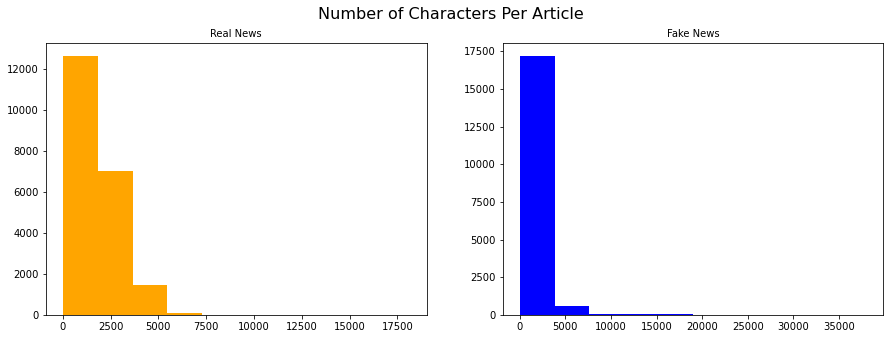

In [24]:
real_news_char = df[df.target == 0].num_char
fake_news_char = df[df.target == 1].num_char
hist_plot(real_news_char, fake_news_char, title='Number of Characters Per Article')


In [25]:
stats_val(real_news_char, fake_news_char)

----Real News----
Mean:  1737.249952821287  Mode:  0    384
dtype: int64  Median:  1619.0
----Fake News----
Mean:  1727.6313613764594  Mode:  0    64
dtype: int64  Median:  1528.0


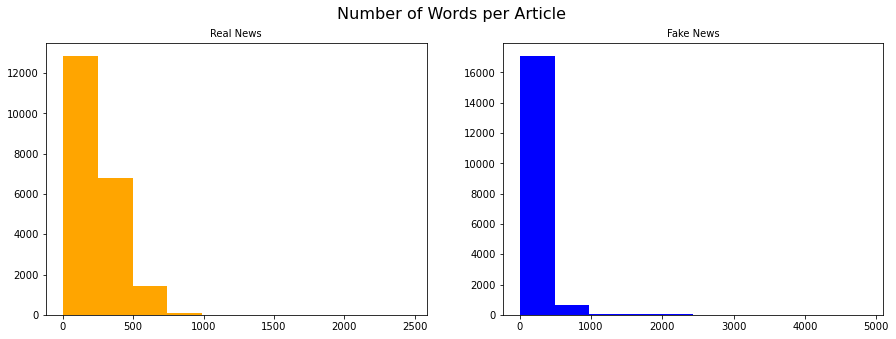

In [26]:
real_news_words = df[df.target == 0].num_words
fake_news_words = df[df.target == 1].num_words
hist_plot(real_news_words, fake_news_words, title='Number of Words per Article')

In [27]:
stats_val(real_news_words, fake_news_words)

----Real News----
Mean:  234.10723721456878  Mode:  0    52
dtype: int64  Median:  218.0
----Fake News----
Mean:  234.46444332718843  Mode:  0    196
dtype: int64  Median:  209.0


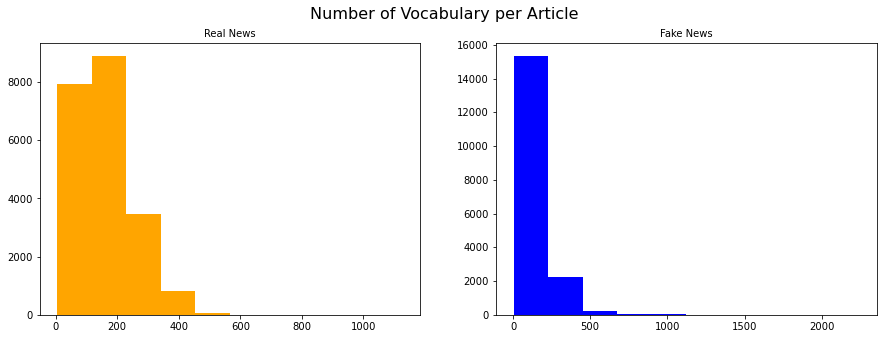

In [28]:
real_news_vocab = df[df.target == 0].num_vocab
fake_news_vocab = df[df.target == 1].num_vocab
hist_plot(real_news_vocab, fake_news_vocab, title ='Number of Vocabulary per Article')

In [29]:
stats_val(real_news_vocab, fake_news_vocab)

----Real News----
Mean:  155.94942441970184  Mode:  0    43
dtype: int64  Median:  149.0
----Fake News----
Mean:  161.56589017373332  Mode:  0    149
dtype: int64  Median:  151.0


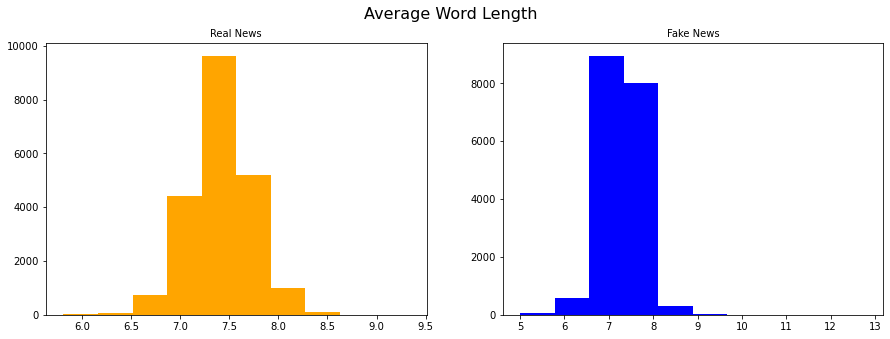

In [32]:
real_news_ave_word_length = df[df.target == 0].ave_word_length
fake_news_ave_word_length = df[df.target == 1].ave_word_length
hist_plot(real_news_ave_word_length, fake_news_ave_word_length, title ='Average Word Length')

In [33]:
stats_val(real_news_ave_word_length, fake_news_ave_word_length)

----Real News----
Mean:  7.418389660258306  Mode:  0    7.5
dtype: float64  Median:  7.415336233889172
----Fake News----
Mean:  7.29731121831641  Mode:  0    7.0
dtype: float64  Median:  7.3076923076923075


### Wordcloud
- There are 3 wordclouds generated:
>1. Whole dataset
>2. Real news
>3. Fake

In [56]:
#create df for corpus
df_corpus = df.title_text
real_news = df[df.target == 0].title_text
fake_news = df[df.target == 1].title_text

#function to convert list into string
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 

#instantiate listToString function
df_corpus = listToString(df_corpus)
real_corpus_str = listToString(real_news)
fake_corpus_str = listToString(fake_news)

In [88]:
#function to generate word cloud
def wordcloud_gen(news_str, image_name):
    plt.figure(figsize = (20,20))
    d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

    # read the mask / color image taken from
    coloring = np.array(Image.open(path.join(d, image_name)))
    stopwords = set(STOPWORDS)

    wc = WordCloud(background_color="white", max_words = 2000 , width = 1600 , height = 800, mask=coloring,
               stopwords=stopwords, max_font_size=80, random_state=42)

    # generate word cloud
    wc.generate(news_str)

    # create coloring from image
    image_colors = ImageColorGenerator(coloring)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off");

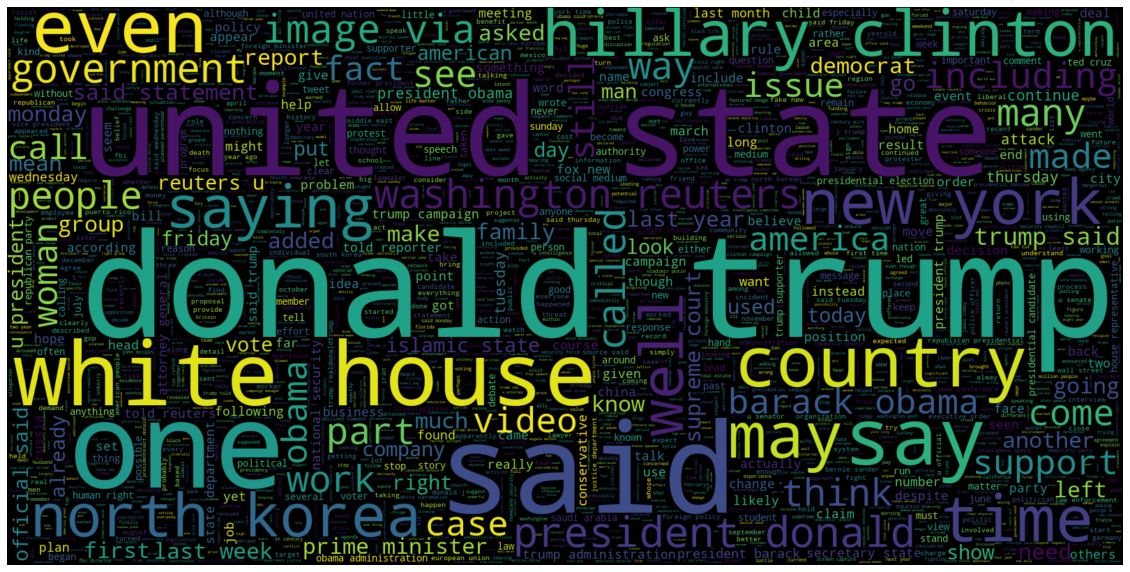

In [41]:
plt.figure(figsize = (20,20)) # Text from the real news articles
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(df_corpus)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show();

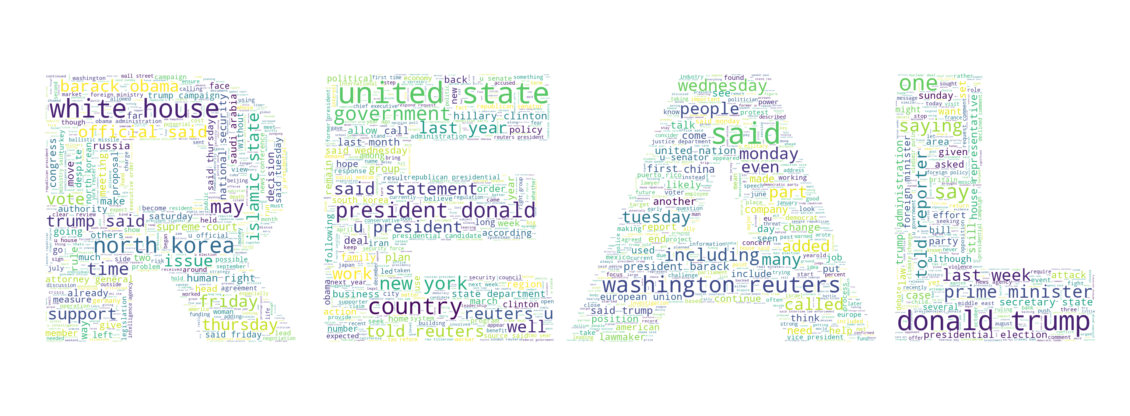

In [89]:
wordcloud_gen(real_corpus_str, image_name="real_news.jpg")

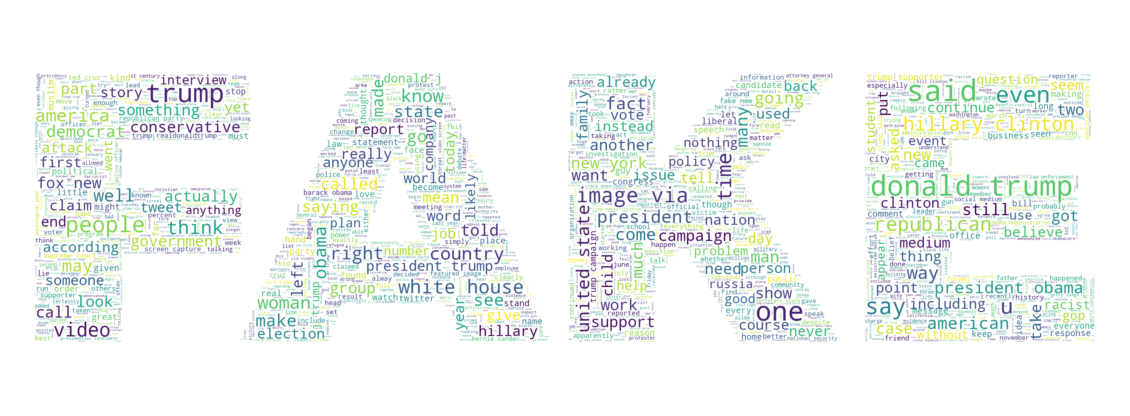

In [90]:
wordcloud_gen(fake_corpus_str, image_name="fake_news.jpg")

In [38]:
#tokenization
real_news = df[df.target == 0]
fake_news = df[df.target == 1]

tokenized_df = df['title_text'].apply(lambda x: list(ngrams(x.split(), 2)))
tokenized_real = real_news['title_text'].apply(lambda x: list(ngrams(x.split(), 2)))
tokenized_fake = fake_news['title_text'].apply(lambda x: list(ngrams(x.split(), 2)))

In [53]:
def generate_ngrams(tokenized_df,title):
    l = reduce(lambda x, y: list(x)+list(y), zip(tokenized_df))
    flatten = [item for sublist in l for item in sublist]
    counts = Counter(flatten).most_common()
    temp_df = pd.DataFrame.from_records(counts, columns=['Phrase', 'Count'])
    temp_df['Phrase']= temp_df['Phrase'].apply(lambda x: ' '.join([w for w in x]))

    temp_df = temp_df.nlargest(columns="Count", n = 10) 
    plt.figure(figsize=(8,4))
    ax = sns.barplot(data=temp_df, y= "Phrase", x = "Count")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation=45)
    fig.suptitle(title, fontsize=16)
    plt.show()

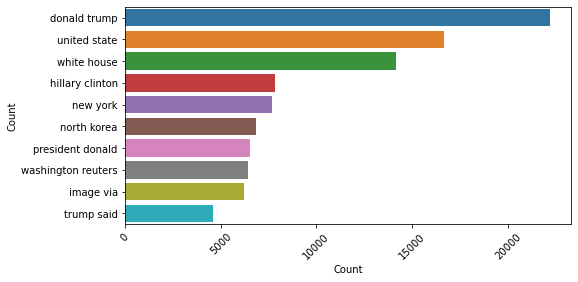

In [54]:
generate_ngrams(tokenized_df, title='N-gram of whole dataset')

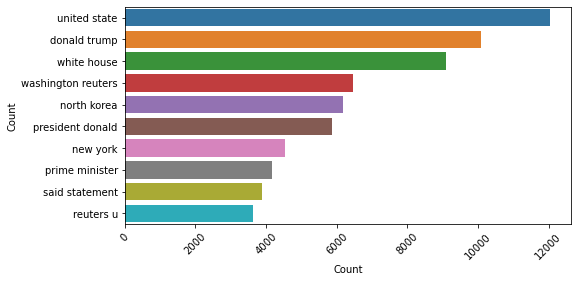

In [55]:
generate_ngrams(tokenized_real, title='N-gram of real news dataset')

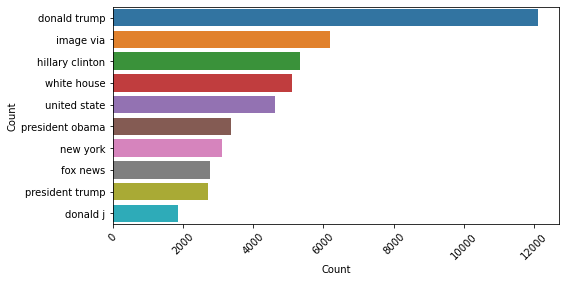

In [56]:
generate_ngrams(tokenized_fake, title='N-gram of fake news dataset')